In [1]:
import pandas as pd

SELECTED_COUNTRIES = [
    'AND', 'ARG', 'AUS', 'ARM', 'BGD', 'BOL', 'BRA', 'CAN', 'CHL', 'CHN', 'COL', 'CYP', 'CZE', 'ECU', 'EGY', 'ETH',
    'DEU', 'GRC', 'GBR', 'GTM', 'HKG', 'IRL', 'IDN', 'IND', 'IRN', 'IRQ', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'LBN',
    'LBY', 'MDV', 'MEX', 'MYS', 'MNG', 'MAR', 'MMR', 'NLD', 'NZL', 'NIC', 'NGA', 'PAK', 'PER', 'PHL', 'PRI', 'ROU',
    'RUS', 'SGP', 'SRB', 'SVK', 'KOR', 'TJK', 'THA', 'TUR', 'TUN', 'UKR', 'USA', 'URY', 'UZB', 'VEN', 'VNM', 'ZWE'
]

In [4]:
def clean_health_data(raw_path, output_path, countries=SELECTED_COUNTRIES):
    df = pd.read_csv(raw_path, skiprows=4)

    df = df[df['Country Code'].isin(countries)]

    years = [str(y) for y in range(1980, 2024)]
    df = df[['Country Name', 'Country Code'] + years]

    df_long = df.melt(
        id_vars=['Country Name', 'Country Code'],
        var_name='Year',
        value_name='Health_Expenditure'
    )

    df_long = df_long.rename(columns={
        'Country Name': 'Country',
        'Country Code': 'ISO3'
    })

    df_long['Year'] = df_long['Year'].astype(int)
    df_long = df_long.sort_values(by=['Country', 'Year']).reset_index(drop=True)

    df_long.to_csv(output_path, index=False)
    return df_long

In [ ]:
df_health = clean_health_data(
    '../data/raw/health_expenditure_raw.csv',
    '../data/interim/health_expenditure_1.csv' #Health Expenditure up to 2022
)
df_health

,Country,ISO3,Year,Health_Expenditure
0,Andorra,AND,1980,NaN
1,Andorra,AND,1981,NaN
2,Andorra,AND,1982,NaN
3,Andorra,AND,1983,NaN
4,Andorra,AND,1984,NaN
...,...,...,...,...
2811,Zimbabwe,ZWE,2019,3.232678
2812,Zimbabwe,ZWE,2020,2.954401
2813,Zimbabwe,ZWE,2021,2.785717
2814,Zimbabwe,ZWE,2022,3.628807


In [18]:
def GDP_percapita(raw_path, output_path, countries=SELECTED_COUNTRIES):
    df = pd.read_csv(raw_path, skiprows=4)

    df = df[df['Country Code'].isin(countries)]

    years = [str(y) for y in range(1960, 2024)]
    df = df[['Country Name', 'Country Code'] + years]

    df_long = df.melt(
        id_vars=['Country Name', 'Country Code'],
        var_name='Year',
        value_name='GDP_percapita'
    )

    df_long = df_long.rename(columns={
        'Country Name': 'Country',
        'Country Code': 'ISO3'
    })

    df_long['Year'] = df_long['Year'].astype(int)
    df_long = df_long.sort_values(by=['Country', 'Year']).reset_index(drop=True)

    df_long.to_csv(output_path, index=False)
    return df_long

In [19]:
df_gdp = GDP_percapita(
    '../data/raw/GDP_percapita.csv',
    '../data/interim/GDP_percapita_1.csv' #GDP percapita all year avail for selected countries
)
df_gdp

,Country,ISO3,Year,GDP_percapita
0,Andorra,AND,1960,NaN
1,Andorra,AND,1961,NaN
2,Andorra,AND,1962,NaN
3,Andorra,AND,1963,NaN
4,Andorra,AND,1964,NaN
...,...,...,...,...
4091,Zimbabwe,ZWE,2019,1684.027904
4092,Zimbabwe,ZWE,2020,1730.413489
4093,Zimbabwe,ZWE,2021,1724.387731
4094,Zimbabwe,ZWE,2022,2040.552459


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load the data (you already did this)
df_gdp = pd.read_csv("../data/interim/GDP_percapita_1.csv")

# Store updated rows
projected_list = []

# Loop by country
for country, group in df_gdp.groupby("ISO3"):
    group = group.sort_values("Year").copy()

    # Training data: all available years < 2024 with non-missing GDP
    train = group[(group["Year"] < 2024) & (group["GDP_percapita"].notna())]

    if len(train) >= 5:  # Optional: require minimum data points
        X = train[["Year"]]
        y = np.log(train["GDP_percapita"])

        model = LinearRegression().fit(X, y)

        # Generate future years from 2024 to 2050
        future_years = list(range(2024, 2051))
        future_df = pd.DataFrame({
            "Country": group["Country"].iloc[0],
            "ISO3": country,
            "Year": future_years
        })

        # Predict log(GDP) and back-transform
        X_future = future_df[["Year"]]
        y_pred_log = model.predict(X_future)
        future_df["GDP_percapita"] = np.exp(y_pred_log)

        # Combine historical + future
        group = pd.concat([group, future_df], ignore_index=True)

    # Append
    projected_list.append(group)

# Final full dataset
df_gdp_projected = pd.concat(projected_list, ignore_index=True)

df_gdp_projected.to_csv("../data/interim/GDP_percapita_2.csv", index=False) #Projected to 2050 using long history from 1960

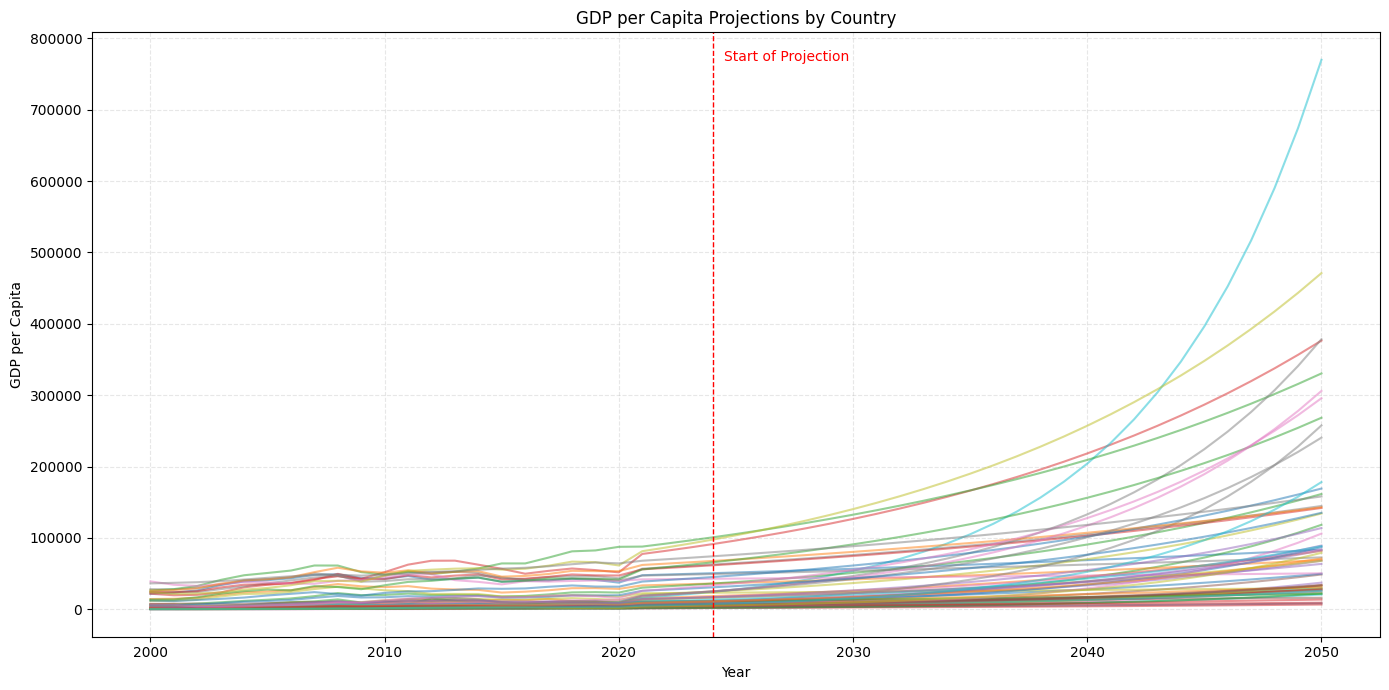

In [35]:
import matplotlib.pyplot as plt

# Load the projected dataset (if not already)
df = pd.read_csv("../data/interim/health_projection_3.csv")

# Plot
plt.figure(figsize=(14, 7))

for iso, group in df.groupby("ISO3"):
    plt.plot(group["Year"], group["GDP_percapita"], alpha=0.5)  # light lines

# Add vertical line to mark the start of projection (2024)
plt.axvline(x=2024, color='red', linestyle='--', linewidth=1)
plt.text(2024.5, plt.ylim()[1]*0.95, 'Start of Projection', color='red')

plt.title("GDP per Capita Projections by Country")
plt.xlabel("Year")
plt.ylabel("GDP per Capita")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [36]:
# Filter for the year 2050
df_2050 = df[df["Year"] == 2050].copy()

# Sort by GDP_percapita descending and get top 10
top10 = df_2050.sort_values("GDP_percapita", ascending=False).head(10)

# Display result
print(top10[["Country", "ISO3", "GDP_percapita"]])

                 Country ISO3  GDP_percapita
509                China  CHN  769926.516091
2498           Singapore  SGP  471071.096808
1376          Kazakhstan  KAZ  378464.697423
203            Australia  AUS  376541.374833
1223             Ireland  IRL  330502.609666
2345             Romania  ROU  305970.310295
2957             Uruguay  URY  295808.886165
2039         New Zealand  NZL  268431.667509
1835            Mongolia  MNG  257655.084221
2396  Russian Federation  RUS  240555.382313


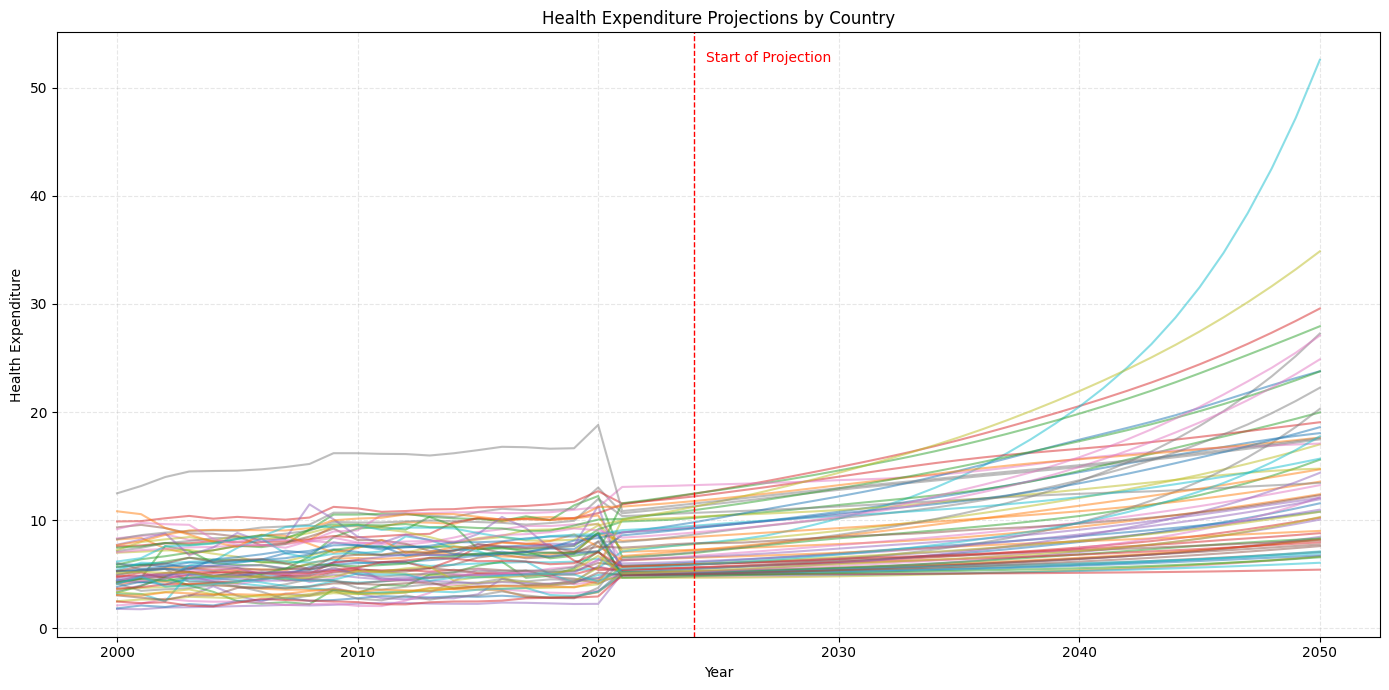

In [28]:
# Load the projected dataset (if not already)
df = pd.read_csv("../data/interim/health_projection_3.csv")

# Plot
plt.figure(figsize=(14, 7))

for iso, group in df.groupby("ISO3"):
    plt.plot(group["Year"], group["Health_Expenditure"], alpha=0.5)  # light lines

# Add vertical line to mark the start of projection (2024)
plt.axvline(x=2024, color='red', linestyle='--', linewidth=1)
plt.text(2024.5, plt.ylim()[1]*0.95, 'Start of Projection', color='red')

plt.title("Health Expenditure Projections by Country")
plt.xlabel("Year")
plt.ylabel("Health Expenditure")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Filter for the year 2050
df_2050 = df[df["Year"] == 2050].copy()

# Sort by Health Expenditure descending and get top 10
top10 = df_2050.sort_values("Health_Expenditure", ascending=False).head(10)

# Display result
print(top10[["Country", "ISO3", "Health_Expenditure"]])

                 Country ISO3  Health_Expenditure
509                China  CHN           52.571563
2498           Singapore  SGP           34.865716
203            Australia  AUS           29.578471
1223             Ireland  IRL           27.937114
1376          Kazakhstan  KAZ           27.265337
2345             Romania  ROU           27.078882
2957             Uruguay  URY           24.880158
1478         Korea, Rep.  KOR           23.777035
2039         New Zealand  NZL           23.763558
2396  Russian Federation  RUS           22.253652
